In [3]:
!pip install -U seaborn

     |████████████████████████████████| 286kB 8.5MB/s 
  Found existing installation: seaborn 0.10.1
    Uninstalling seaborn-0.10.1:
      Successfully uninstalled seaborn-0.10.1


In [4]:
import seaborn as sns
import pandas as pd
import matplotlib.pyplot as plt
import os
import re

from google.colab import drive

%matplotlib inline

In [5]:
sns.set_theme()

In [6]:
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [7]:
code_lines_to_function = dict(
    gdrive=dict(
        reading='content =',
        opening='with open',
        total='Total time'
    ),
    gcsfuse=dict(
        reading='content =',
        opening='with open',
        total='Total time'
    ),
    storage_api=dict(
        reading='download_to_filename',
        opening='list_blobs',
        total='Total time'
    ),
)

In [8]:
def parse(strategy='gdrive'):
  output_data = pd.DataFrame(
      columns=[
          'orig_folder',
          'runtime_type',
          'region',
          'strategy',
          'opening',
          'reading',
          'total',
          'amount_read_in_kB',
          'offset'                   
  ])
  for folder_name in os.listdir('/content/gdrive/My Drive/ML_data/'):
    if not re.match('IO_profiling_output_', folder_name):
      print('Skipping ' + folder_name)
      continue
    print('Reading ' + folder_name)
 
    rt_type = 'gpu' if '_gpu' in folder_name else 'tpu' if '_tpu' in folder_name else 'cpu'
 
    region = 'Unspecified'
    try:
      with open('/content/gdrive/My Drive/ML_data/'+ folder_name + '/region.txt', 'r') as f:
        region = f.readlines()[0]
    except FileNotFoundError:
      pass
 
    file_opening = list()
    file_reading = list()
    total = list()
    amounts_read = list()
    for offset in range(0,551,50):
      filename = '/content/gdrive/My Drive/ML_data/'+ folder_name + '/test_from_'+ strategy + '_' + str(offset) + '_t0.csv'
      with open(filename) as f:
        lines = f.readlines()
      file_opening.append(
          float([x for x in lines if code_lines_to_function[strategy]['opening'] in x][0].split()[3])
      )
      file_reading.append(
          float([x for x in lines if code_lines_to_function[strategy]['reading'] in x][0].split()[3])
      )
      total.append(
          float([x for x in lines if code_lines_to_function[strategy]['total'] in x][0].split()[2])
      )

      short_strategy = strategy if strategy != 'storage_api' else 'api'
      size_filename = '/content/gdrive/My Drive/ML_data/IO_profiling_output_twentyfourth/' + short_strategy + '-size_' + str(offset) + '.txt'
      with open(size_filename, 'r') as f:
        amounts_read.append(float(f.readlines()[0])*1e-3)

    output_data = pd.concat((
        output_data,                    
        pd.DataFrame(dict(
          orig_folder=folder_name,
          opening=file_opening,
          reading=file_reading,
          total=total,
          runtime_type=rt_type,
          region=region,
          strategy=strategy,
          offset=list(range(0,551,50)),
          second_reading=False,
          amount_read_in_kB=amounts_read
        ))),
        axis=0)
    
    found_second_reading_files = True
    file_opening = list()
    file_reading = list()
    total = list()
    lookup_strategy = 'gdrive' # it's the same for all, but can get confusing if I have to distinguish from first reading
    for offset in range(0,551,50):
      filename = '/content/gdrive/My Drive/ML_data/'+ folder_name + '/test_from_'+ strategy + '_' + str(offset) + '_t1.csv'
      try:
        with open(filename) as f:
          lines = f.readlines()
      except FileNotFoundError:
        found_second_reading_files = False
        break
      file_opening.append(
          float([x for x in lines if code_lines_to_function[lookup_strategy]['opening'] in x][0].split()[3])
      )
      file_reading.append(
          float([x for x in lines if code_lines_to_function[lookup_strategy]['reading'] in x][0].split()[3])
      )
      total.append(
          float([x for x in lines if code_lines_to_function[lookup_strategy]['total'] in x][0].split()[2])
      )

    if found_second_reading_files:
      output_data = pd.concat((
          output_data,                    
          pd.DataFrame(dict(
            orig_folder=folder_name,
            opening=file_opening,
            reading=file_reading,
            total=total,
            runtime_type=rt_type,
            region=region,
            strategy=strategy,
            offset=list(range(0,551,50)),
            second_reading=True,
            amount_read_in_kB=amounts_read
          ))),
          axis=0)
    
  return output_data

In [ ]:
gdrive = parse('gdrive')
fuse = parse('gcsfuse')
api = parse('storage_api')


In [10]:
data = pd.concat((gdrive, fuse, api))

In [11]:
data['opening [sec]'] = data.opening*1e-6

In [12]:
data['read_bw_in_MB_per_sec'] = 1e-3*data.amount_read_in_kB/(data.reading*1e-6)
data['MB_processed_per_sec'] = 1e-3*data.amount_read_in_kB/(data.total)

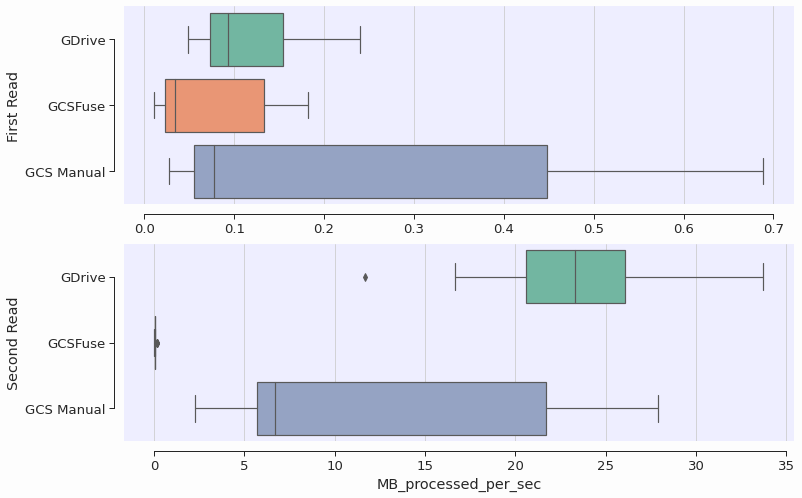

In [15]:
sns.set_context('paper', font_scale=1.5)
with sns.axes_style("ticks", rc={'axes.facecolor': '#eeeeff',
                                 'figure.facecolor':'#fdfdfd',
                                 'axes.grid': True, 
                                 'font.sans-serif': 'BlinkMacSystemFont'}):
  fig, axs = plt.subplots(2,1, figsize=(12,8))
  sns.boxplot(data=data[data.second_reading == False], y='strategy', x='MB_processed_per_sec', ax=axs[0], palette='Set2')
  sns.boxplot(data=data[data.second_reading], y='strategy', x='MB_processed_per_sec', ax=axs[1], palette='Set2')

  axs[0].set_xlabel('')
  axs[0].set_ylabel('First Read')
  axs[1].set_ylabel('Second Read')

  axs[0].set_yticklabels(['GDrive', 'GCSFuse', 'GCS Manual'])
  axs[1].set_yticklabels(['GDrive', 'GCSFuse', 'GCS Manual'])


  sns.despine(offset=10, trim=True)

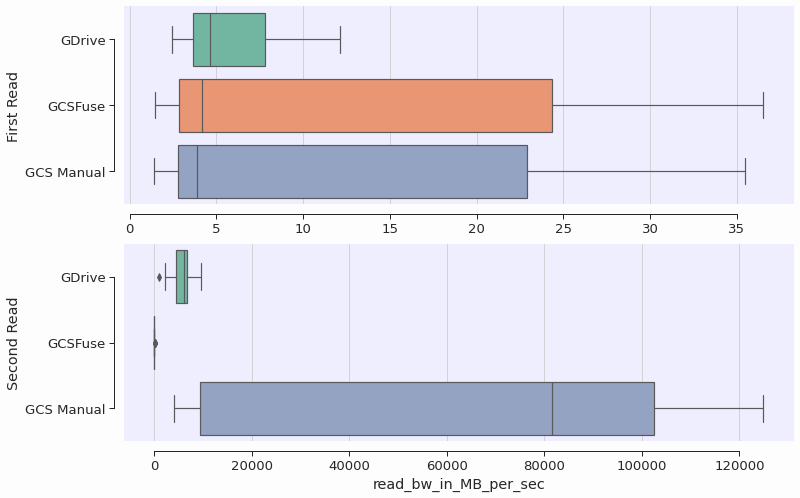

In [26]:
sns.set_context('paper', font_scale=1.5)
with sns.axes_style("ticks", rc={'axes.facecolor': '#eeeeff',
                                 'figure.facecolor':'#fdfdfd',
                                 'axes.grid': True, 
                                 'font.sans-serif': 'BlinkMacSystemFont'}):
  fig, axs = plt.subplots(2,1, figsize=(12,8))
  sns.boxplot(data=data[data.second_reading == False], y='strategy', x='read_bw_in_MB_per_sec',
                 ax=axs[0], palette='Set2')
  sns.boxplot(data=data[data.second_reading], y='strategy', x='read_bw_in_MB_per_sec',
                 ax=axs[1], palette='Set2')

  axs[0].set_xlabel('')
  axs[0].set_ylabel('First Read')
  axs[1].set_ylabel('Second Read')

  axs[0].set_yticklabels(['GDrive', 'GCSFuse', 'GCS Manual'])
  axs[1].set_yticklabels(['GDrive', 'GCSFuse', 'GCS Manual'])


  sns.despine(offset=10, trim=True)

In [86]:
second_read = data[data.second_reading]

In [87]:
compare_reads = second_read.merge(data, on=['orig_folder', 'offset', 'strategy'])

In [88]:
compare_reads['ratio'] = compare_reads.MB_processed_per_sec_y/compare_reads.MB_processed_per_sec_x

In [89]:
compare_reads.groupby(['strategy']).describe()['ratio']

,count,mean,std,min,25%,50%,75%,max
strategy,,,,,,,,
gcsfuse,120.0,1.616295,1.533545,0.770389,0.884737,1.000000,1.0,5.438019
gdrive,120.0,0.502394,0.499694,0.002200,0.004476,0.506654,1.0,1.000000
storage_api,120.0,0.509642,0.492445,0.007947,0.021461,0.517105,1.0,1.000000


In [17]:
data['macro_region'] = None
data['macro_region'] = data.region.str.split(pat=':', expand=True)

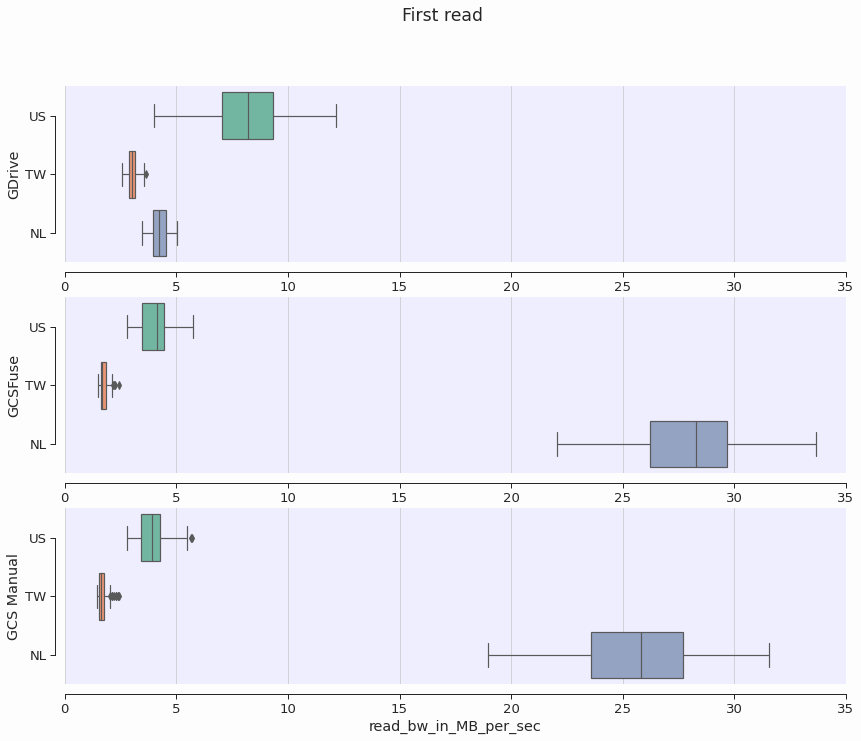

In [24]:
sns.set_context('paper', font_scale=1.5)
with sns.axes_style("ticks", rc={'axes.facecolor': '#eeeeff',
                                 'figure.facecolor':'#fdfdfd',
                                 'axes.grid': True, 
                                 'font.sans-serif': 'BlinkMacSystemFont'}):
  fig, axs = plt.subplots(3,1, figsize=(14,11))
  fig.suptitle('First read')
  sns.boxplot(data=data[(data.macro_region != 'Unspecified') & (data.strategy == 'gdrive') & (data.second_reading == False)],
              y='macro_region', x='read_bw_in_MB_per_sec', ax=axs[0], palette='Set2')
  sns.boxplot(data=data[(data.macro_region != 'Unspecified') & (data.strategy == 'gcsfuse') & (data.second_reading == False)],
              y='macro_region', x='read_bw_in_MB_per_sec', ax=axs[1], palette='Set2')
  sns.boxplot(data=data[(data.macro_region != 'Unspecified') & (data.strategy == 'storage_api') & (data.second_reading == False)],
              y='macro_region', x='read_bw_in_MB_per_sec', ax=axs[2], palette='Set2')

  axs[0].set_xlabel('')
  axs[0].set_ylabel('GDrive')
  axs[1].set_ylabel('GCSFuse')
  axs[2].set_ylabel('GCS Manual')

  axs[0].set_xlim([0., 35])
  axs[1].set_xlim([0., 35])
  axs[2].set_xlim([0., 35])

  sns.despine(offset=10, trim=True)

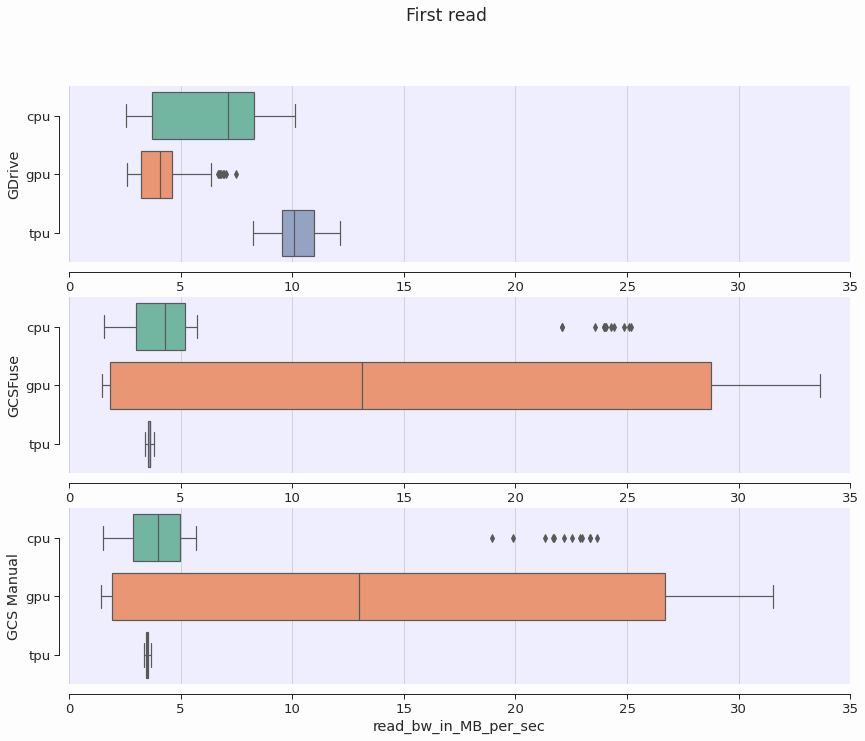

In [27]:
sns.set_context('paper', font_scale=1.5)
with sns.axes_style("ticks", rc={'axes.facecolor': '#eeeeff',
                                 'figure.facecolor':'#fdfdfd',
                                 'axes.grid': True, 
                                 'font.sans-serif': 'BlinkMacSystemFont'}):
  fig, axs = plt.subplots(3,1, figsize=(14,11))
  fig.suptitle('First read')
  sns.boxplot(data=data[(data.macro_region != 'Unspecified') & (data.strategy == 'gdrive') & (data.second_reading == False)],
              y='runtime_type', x='read_bw_in_MB_per_sec', ax=axs[0], palette='Set2')
  sns.boxplot(data=data[(data.macro_region != 'Unspecified') & (data.strategy == 'gcsfuse') & (data.second_reading == False)],
              y='runtime_type', x='read_bw_in_MB_per_sec', ax=axs[1], palette='Set2')
  sns.boxplot(data=data[(data.macro_region != 'Unspecified') & (data.strategy == 'storage_api') & (data.second_reading == False)],
              y='runtime_type', x='read_bw_in_MB_per_sec', ax=axs[2], palette='Set2')

  axs[0].set_xlabel('')
  axs[0].set_ylabel('GDrive')
  axs[1].set_ylabel('GCSFuse')
  axs[2].set_ylabel('GCS Manual')

  axs[0].set_xlim([0., 35])
  axs[1].set_xlim([0., 35])
  axs[2].set_xlim([0., 35])

  sns.despine(offset=10, trim=True)